<h1>MLPClassifier</h1>

##Import + Montaggio cartella Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [3]:
!pip install tqdm_joblib

In [4]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV, PredefinedSplit, ParameterGrid
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
from tqdm_joblib import tqdm_joblib
from tqdm.autonotebook import tqdm
from joblib import parallel_backend
from tqdm import tqdm
tqdm.pandas()

import string
import nltk

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

/Users/angelonazzaro/work/nlp/.venv/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angelonazzaro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/angelonazzaro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/angelonazzaro/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/angelonazzaro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Caricamento del dataset

In [5]:
df = pd.read_csv('../data/trainWithFeaturesAndEmbeddings.csv')
df.head()

,text,topic,sentiment,length,topicWords,topicWordsCount,positiveCount,negativeCount,hasNo,embed_0,...,embed_374,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383
0,Good Afternoon from a rather cool and damp Ess...,Books & Literature,Positive,44,['author'],1,3,0,0,-0.009258,...,-0.011806,-0.040050,-0.028320,-0.032246,0.013747,0.054467,0.060302,0.093453,-0.090176,0.011050
1,2) My favorite fictional spice is melange. My ...,General Activities,Neutral,16,[],0,2,1,0,-0.066764,...,-0.044040,-0.040336,-0.050697,0.083287,0.021824,-0.114995,0.034062,0.049423,-0.062629,-0.008898
2,Guess the German utensil! https://https://t.co...,Trivia & Fun Facts,Positive,9,[],0,0,0,0,-0.067560,...,0.006027,0.038677,0.040306,-0.042645,0.012359,0.042093,0.029526,-0.007695,-0.031263,0.125133
3,I am quite tempted to spend the entirety of th...,Fashion & Style,Negative,21,[],0,0,0,0,-0.060903,...,0.008680,0.094215,0.019267,-0.033533,-0.053666,-0.031781,-0.021230,-0.114671,-0.090589,0.035798
4,I heard different on cnn,Journalism,Neutral,5,[],0,0,0,0,0.040691,...,0.099750,0.041532,-0.033229,-0.098661,0.032493,-0.044346,-0.008297,-0.068045,0.078471,-0.020324


In [6]:
# Campionamento stratificato
df.dropna(subset=['sentiment'], inplace=True)
df, _ = train_test_split(
  df,
  train_size=100_000,
  stratify=df['sentiment'],
  random_state=42
)

In [7]:
df_test = pd.read_csv('../data/testWithFeaturesAndEmbeddings.csv')
df_test.head()

,text,topic,sentiment,length,topicWords,topicWordsCount,positiveCount,negativeCount,hasNo,embed_0,...,embed_374,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383
0,thank you! 🥹❤️❤️,Fashion & Style,Positive,8,[],0,1,0,0,-0.025975,...,-0.019321,0.040424,-0.014585,0.038854,0.056717,0.119614,0.014514,0.120229,-0.027037,0.030239
1,The Next Chapter for NativeScript: nStudio by ...,Programming,Neutral,17,['javascript'],1,0,0,0,-0.068502,...,0.022137,-0.038811,-0.070492,-0.030029,-0.046116,0.002696,-0.022367,0.102057,0.002136,0.029075
2,lwj doesn't speak for longer than he would've ...,Social Media,Negative,63,[],0,1,0,0,-0.005183,...,-0.002973,0.010910,0.036041,0.007441,-0.064407,-0.065380,0.042773,0.007973,-0.001446,0.040114
3,"The truth is ""a liberal reassurance narrative?""",Journalism,Neutral,10,[],0,1,0,0,0.068206,...,0.040749,-0.037523,-0.047591,-0.059627,-0.055182,-0.004068,-0.040202,0.042814,0.081529,-0.051749
4,Such a great film.,Movies & TV,Positive,5,['film'],1,1,0,0,-0.059131,...,0.067459,0.010276,0.016515,-0.057109,-0.004752,0.025960,0.032027,-0.006660,0.000614,0.001283


In [8]:
# Campionamento stratificato
df_test.dropna(subset=['sentiment'], inplace=True)
df_test, _ = train_test_split(
  df_test,
  train_size=20_000,
  stratify=df_test['sentiment'],
  random_state=42
)

In [9]:
df_val = pd.read_csv('../data/validationWithFeaturesAndEmbeddings.csv')
df_val.head()

,text,topic,sentiment,length,topicWords,topicWordsCount,positiveCount,negativeCount,hasNo,embed_0,...,embed_374,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383
0,Quick plug on this new platform for some of my...,Social Media,Neutral,52,[],0,1,2,0,-0.065827,...,-0.004585,-0.058114,0.033320,0.102114,-0.053937,0.087153,0.105939,-0.026751,-0.048552,0.044566
1,ok whatthefuck,Gaming,Neutral,2,[],0,0,0,0,0.001517,...,0.112817,-0.007861,0.016383,0.031305,-0.021063,0.024053,-0.002595,0.020050,0.092061,-0.033776
2,Paketocas https://twitter.com/324cat/status/16...,Social Media,Neutral,2,[],0,0,0,0,-0.062472,...,0.017665,0.009573,-0.017845,-0.084442,0.014240,-0.030893,0.067415,0.004409,0.036922,-0.007215
3,All that dreaming 😴 of food has exhausted her ...,General Activities,Positive,17,[],0,0,1,0,0.047092,...,0.013538,-0.036066,0.028027,-0.020379,-0.030251,0.096698,0.068467,0.015141,-0.089595,0.007898
4,this is def the Mental Illness™ talking but i ...,Mental Health,Neutral,20,[],0,2,1,0,-0.024350,...,0.058399,0.049774,0.031252,0.007518,-0.061681,0.016520,0.101300,0.105141,0.010822,-0.024825


In [10]:
# Campionamento stratificato
df_val.dropna(subset=['sentiment'], inplace=True)
df_val, _ = train_test_split(
  df_val,
  train_size=20_000,
  stratify=df_val['sentiment'],
  random_state=42
)

##Preprocessing

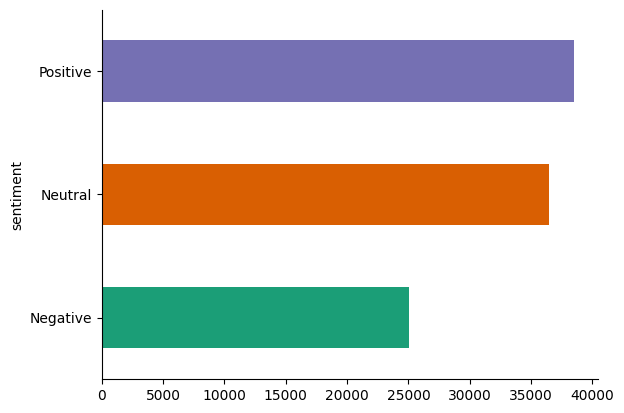

In [11]:
df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 307652 to 97330
Columns: 393 entries, text to embed_383
dtypes: float64(384), int64(5), object(4)
memory usage: 300.6+ MB


In [13]:
df.keys()

Index(['text', 'topic', 'sentiment', 'length', 'topicWords', 'topicWordsCount',
       'positiveCount', 'negativeCount', 'hasNo', 'embed_0',
       ...
       'embed_374', 'embed_375', 'embed_376', 'embed_377', 'embed_378',
       'embed_379', 'embed_380', 'embed_381', 'embed_382', 'embed_383'],
      dtype='object', length=393)

In [14]:
df = df.dropna(subset=['text', 'topic', 'sentiment', 'length', 'topicWords', 'topicWordsCount', 'positiveCount', 'negativeCount', 'hasNo'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 307652 to 97330
Columns: 393 entries, text to embed_383
dtypes: float64(384), int64(5), object(4)
memory usage: 300.6+ MB


In [15]:
# df_val = df_val.dropna(subset=['text', 'topic', 'sentiment', 'length', 'topicWords', 'topicWordsCount', 'positiveCount', 'negativeCount', 'hasNo'])
df_test = df_test.dropna(subset=['text', 'topic', 'sentiment', 'length', 'topicWords', 'topicWordsCount', 'positiveCount', 'negativeCount', 'hasNo'])

In [16]:
STOPWORDS_EN    = set(stopwords.words('english'))
NEGATION_WORDS = {"n't", "not", "no", "never"}
PUNCTUATION    = set(string.punctuation)
LEMMATIZER     = WordNetLemmatizer()

In [17]:
def normalize_text(text, lemmatizer, lemmatizer_func="lemmatize"):
  text = text.lower()
  tokens = word_tokenize(text)
  lemmatize = getattr(lemmatizer, lemmatizer_func)
  normalized = []

  prefix_NOT = False
  for token in tokens:
    if token in NEGATION_WORDS:
      prefix_NOT = True
      normalized.append(token)
      continue

    if token in PUNCTUATION:
      prefix_NOT = False
      normalized.append(token)
      continue

    if token in STOPWORDS_EN:
      continue

    token = lemmatize(token)
    if prefix_NOT:
      token = f"NOT_{token}"
    normalized.append(token)

  return normalized

In [18]:
df['text_tokens'] = df['text'].progress_apply(lambda x: normalize_text(x, LEMMATIZER, "lemmatize"))

df = df[df['text_tokens'].apply(lambda tokens: len(tokens) > 0)].copy()
df.reset_index(drop=True, inplace=True)

100%|██████████| 100000/100000 [00:13<00:00, 7329.51it/s]


In [19]:
# df_val['text_tokens'] = df_val['text'].progress_apply(lambda x: normalize_text(x, LEMMATIZER, "lemmatize"))
df_test['text_tokens']= df_test['text'].progress_apply(lambda x: normalize_text(x, LEMMATIZER, "lemmatize"))

100%|██████████| 19999/19999 [00:02<00:00, 8606.53it/s]


In [20]:
numeric_features = ['length', 'topicWordsCount', 'positiveCount', 'negativeCount', 'hasNo'] 
numeric_transformer = StandardScaler()

categorical_features = ['topic']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

text_features = 'text_tokens'
text_transformer = CountVectorizer(
  analyzer=lambda tokens: tokens,
  lowercase=False,
  token_pattern=None
)

preprocessor = ColumnTransformer(
  transformers=[
      ('num', numeric_transformer, numeric_features),
      ('cat', categorical_transformer, categorical_features),
      ('txt', text_transformer, text_features),
  ],
  remainder='drop',
  sparse_threshold=0
)

##Train/Validation/Test split



In [21]:
X_train = df.drop(columns="sentiment")
y_train = df["sentiment"]

X_val = df_val.drop(columns="sentiment")
y_val = df_val["sentiment"]

X_test = df_test.drop(columns="sentiment")
y_test = df_test["sentiment"]

print(f"Shape X_train: {X_train.shape}, Shape X_val: {X_val.shape},  Shape X_test: {X_test.shape}")

Shape X_train: (99929, 393), Shape X_val: (20000, 392),  Shape X_test: (19999, 393)


In [22]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
# y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

## Definizione MLPClassifier

In [23]:
mlp_base = MLPClassifier(
  hidden_layer_sizes=(50,),
  activation='relu',
  solver='adam',
  alpha=1e-4,
  learning_rate='adaptive',
  learning_rate_init=1e-3,
  max_iter=100,
  early_stopping=True,
  n_iter_no_change=10,
  random_state=42,
  verbose=False
)

pipeline = Pipeline([
  ('preprocessor', preprocessor),
  ('classifier', mlp_base)
])

###Addestramento base

In [ ]:
pipeline.fit(X_train, y_train_encoded)

In [ ]:
y_pred_test = pipeline.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy su TEST: {acc_test:.4f}\n")

print("Classification report (TEST):")
print(classification_report(y_test, y_pred_test))

In [ ]:
# MATRICE DI CONFUSIONE
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
plt.imshow(cm_test, cmap='Blues')
plt.colorbar()
labels = pipeline.named_steps['classifier'].classes_
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.yticks(range(len(labels)), labels)
plt.title("Matrice di confusione - TEST")
for i in range(len(labels)):
  for j in range(len(labels)):
    plt.text(j, i, cm_test[i, j], ha='center', va='center',
            color='white' if cm_test[i, j] > cm_test.max()/2 else 'black')
plt.xlabel("Predetto")
plt.ylabel("Vero")
plt.tight_layout()
plt.show()

###Grid search

In [ ]:
X_train_val = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_train_val = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

n_train = X_train.shape[0]
n_val   = X_val.shape[0]

test_fold = np.concatenate([
  -1 * np.ones(n_train, dtype=int),
    0 * np.ones(n_val,   dtype=int)
])

ps = PredefinedSplit(test_fold=test_fold)

In [ ]:
print("Shape X_train_val:", X_train_val.shape)
print("Shape y_train_val:", y_train_val.shape)
print("Lunghezza test_fold:", len(test_fold))
print("Numero di -1 in test_fold:", np.sum(test_fold == -1)) # n_train
print("Numero di  0 in test_fold:", np.sum(test_fold == 0)) # n_val

In [ ]:
param_grid = {
  'classifier__hidden_layer_sizes': [(50,), (100,)],
  'classifier__alpha': [1e-4, 1e-3, 1e-2],
  'classifier__learning_rate_init': [1e-3, 1e-4]
}

In [ ]:
n_candidates = len(list(ParameterGrid(param_grid)))
n_splits = PredefinedSplit(test_fold).get_n_splits()
total_iter = n_candidates * n_splits

In [ ]:
grid_search = GridSearchCV(
  estimator=pipeline,
  param_grid=param_grid,
  cv=ps,
  scoring='accuracy',
  n_jobs=-1,
  verbose=2
)

In [ ]:
#with tqdm_joblib(tqdm(desc="GridSearch Progress", total=total_iter)) as progress_bar:
grid_search.fit(X_train_val, y_train_val)

In [ ]:
print("Migliori iperparametri (param_grid):")
for k, v in grid_search.best_params_.items():
  print(f"  {k} = {v}")

print(f"\nBest score (accuracy su X_val): {grid_search.best_score_:.4f}")

In [ ]:
best_pipeline = grid_search.best_estimator_
y_pred_test = best_pipeline.predict(X_test)  # valutazione del modello migliore sul test set

In [ ]:
acc_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy finale su TEST: {acc_test:.4f}\n")

print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
labels = best_pipeline.named_steps['classifier'].classes_
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.yticks(range(len(labels)), labels)
plt.title("Matrice di confusione - TEST")
for i in range(len(labels)):
  for j in range(len(labels)):
    plt.text(j, i, cm[i, j], ha='center', va='center',
              color='white' if cm[i,j] > cm.max()/2 else 'black')
plt.xlabel("Predetto")
plt.ylabel("Vero")
plt.tight_layout()
plt.show()

In [ ]:
joblib.dump(best_pipeline, '/content/drive/MyDrive/Progetto_NLP/modelli/grid_search/mlp_sentiment_pipeline_gridsearch.joblib')
# loaded_pipeline = joblib.load('/content/drive/MyDrive/mlp_sentiment_pipeline_gridsearch.joblib')